# CIFAR-10 Image Classification Training Notebook

This notebook implements the training pipeline for CIFAR-10 image classification using PyTorch.

## Overview
- Model architecture loading and configuration
- Data loading and preprocessing
- Training loop with early stopping
- Model evaluation and visualization
---
### Key Features
- **Model Architecture**: Custom CNN/MLP with modern design patterns
- **Data Augmentation**: Mixup and Cutout for improved generalization
- **Optimization**: Adam/SGD with momentum and learning rate scheduling
- **Regularization**: BatchNorm, Dropout, and Label Smoothing
- **Training**: Early stopping and model checkpointing
- **Visualization**: Training metrics and sample predictions
---
## Requirements
- PyTorch
- torchvision
- numpy
- matplotlib
- seaborn
---

_Developed by Pavlo Borysov — June 2025_

🔗 [Project Repository on GitHub](https://github.com/ayri77/CIFAR10-Torch-Classifier)

In [10]:
# Uncomment to install dependencies if running in Colab
# !pip install torch torchvision matplotlib seaborn

### Libraries and environment

#### 📦 Standard & project setup

In [11]:
# Standard library imports
import sys
import os
import json
from pathlib import Path

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Project imports
from utils.paths import MODELS_DIR, DATA_DIR, ARCHITECTURES_DIR
from core.cifar10_classifier import CIFAR10Classifier
import config

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### 🔁 Reproducibility

In [12]:
# Utility imports
from utils.utils import set_seed, set_deterministic, load_architecture

# Set random seed and deterministic behavior
set_seed(config.SEED)
set_deterministic(
    deterministic=config.DETERMINISTIC,
    benchmark=config.BENCHMARK # torch.backends.cudnn.benchmark = True may speed up training if input sizes are fixed
)

🔧 Setting seed: 42


#### 🧠 Core imports (torch, torchvision)

In [13]:
# Deep learning imports
import torch
from torchvision import transforms

#### 📊 Visualization utilities

In [14]:
# Visualization imports
from utils.visualization import (
    show_random_samples,
    show_class_distribution,
    plot_training_history,
    plot_confusion_matrix,
    print_per_class_accuracy
)

#### Model Architecture Details (Sample)
The CNN architecture consists of:
1. **Convolutional Layers**:
   - 4 conv blocks with increasing channels (32→64→128→256)
   - 3x3 kernels with padding for spatial preservation
   - Max pooling for dimensionality reduction

2. **Fully Connected Layers**:
   - Two dense layers (512→256→10)
   - Batch normalization for stable training
   - Dropout for regularization (0.5, 0.3)

3. **Activation Functions**:
   - ReLU for non-linearity
   - Softmax for classification

#### Training Configuration
- **Optimizer**: SGD with momentum (0.9) and weight decay (0.0001)
- **Learning Rate**: 0.01 with ReduceLROnPlateau scheduler
- **Loss Function**: CrossEntropyLoss with label smoothing (0.1)
- **Training Duration**: 200 epochs with early stopping (patience=10)
- **Batch Size**: 256 for efficient training

#### Expected Results
- Validation accuracy: ~80% on CIFAR-10 validation set (10,000 images)
- Final model tested on Kaggle test set with accuracy ≈ 83.56%
- Training time: ~40 minutes
- Model checkpoints and metrics saved in the models directory

🔧 Using config from: `architectures/cnn_mixup_cutout_SGD.json`

### Loading Model Architecture

In [17]:
# Model configuration
model_name = "cnn_320-1920_deepdrop_sched-plateau_mixup0.4_resize126_batch"
metrics_path = os.path.join(MODELS_DIR, model_name, f"{model_name}_metrics.json")

# Load model architecture and configuration
(
    model_type,
    model_kwargs,
    optimizer_cfg,
    criterion_cfg,
    lr_scheduler_cfg,
    augmentation,
    grayscale,
    resize
) = load_architecture(model_name, base_dir=ARCHITECTURES_DIR)

# === Training hyperparameters unpack ===
optimizer_name = optimizer_cfg["name"]
optimizer_kwargs = optimizer_cfg["kwargs"]
criterion_name = criterion_cfg["name"]
criterion_kwargs = criterion_cfg["kwargs"]
lr_scheduler_name = lr_scheduler_cfg["name"]
lr_scheduler_kwargs = lr_scheduler_cfg["kwargs"]

# === Training runtime settings ===
NUM_EPOCHS = 200
PATIENCE = 10

### Dataset Information
CIFAR-10 is a benchmark dataset containing:
- 60,000 32x32 color images
- 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- 50,000 training images and 10,000 test images
- Balanced class distribution

### Data loading and train/test set preparation

In [18]:
# Data loading and preprocessing
from utils.data_utils import (
    compute_mean_std,
    get_transforms,
    load_cifar10_datasets,
    split_train_val,
    create_loaders,
    get_dataset_info
)

# Load raw dataset for visualization
raw_dataset, _ = load_cifar10_datasets(
    data_dir=DATA_DIR,
    transform=transforms.ToTensor(),
    subset="train"
)
class_names = raw_dataset.classes

# Handle grayscale conversion if needed
if grayscale:
    transform_gs = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

# Load training subset (raw) to compute dataset-wide mean and std
mean_std_dataset, _ = load_cifar10_datasets(
    data_dir=DATA_DIR,
    transform=transform_gs if grayscale else transforms.ToTensor(),
    subset="train"
)

📥 Downloading/loading CIFAR-10 datasets to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\data... Loading train dataset
Files already downloaded and verified
✅ Loaded training samples: 50000
📥 Downloading/loading CIFAR-10 datasets to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\data... Loading train dataset
Files already downloaded and verified
✅ Loaded training samples: 50000


#### 🔍 Compute mean and std of CIFAR-10 for normalization

In [19]:
# Compute dataset statistics
mean, std = compute_mean_std(mean_std_dataset)
print(f"📊 Dataset statistics:")
print(f"✅ Mean: {mean}, Std: {std}")

📊 Computing mean and std...
✅ Mean: [0.4913996756076813, 0.48215851187705994, 0.4465310275554657], Std: [0.24703219532966614, 0.24348489940166473, 0.2615877091884613]
📊 Dataset statistics:
✅ Mean: tensor([0.4914, 0.4822, 0.4465]), Std: tensor([0.2470, 0.2435, 0.2616])


#### 🧪 Apply augmentation and grayscale transforms

The transformation pipeline includes:

- `RandomCrop(32, padding=4)`
- `ColorJitter(...)`
- `HorizontalFlip`, `Rotation`, `Affine`
- `Resize` to ensure consistent input shape
- `Cutout(size=8)` for occlusion augmentation
- `Normalize(mean, std)`

In [20]:
# Create data transforms
train_transform = get_transforms(
    mean=mean,
    std=std,
    augmentation=augmentation,
    grayscale=grayscale,
    resize=resize
)

# Load with transformations
train_dataset, _ = load_cifar10_datasets(
    data_dir=DATA_DIR, 
    transform=train_transform, 
    subset="train"
)

🧪 Creating transform pipeline...
🧪 Transform pipeline:
  └─ RandomCrop(size=(32, 32), padding=4)
  └─ ColorJitter(brightness=(0.8, 1.2), contrast=(0.7, 1.3), saturation=(0.4, 1.6), hue=(-0.4, 0.4))
  └─ RandomHorizontalFlip(p=0.5)
  └─ RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
  └─ RandomAffine(degrees=[0.0, 0.0], translate=(0.127, 0.127))
  └─ Resize(size=[126, 126], interpolation=bilinear, max_size=None, antialias=True)
  └─ ToTensor()
  └─ Cutout(size=8)
  └─ Normalize(mean=[0.4913996756076813, 0.48215851187705994, 0.4465310275554657], std=[0.24703219532966614, 0.24348489940166473, 0.2615877091884613])
📥 Downloading/loading CIFAR-10 datasets to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\data... Loading train dataset
Files already downloaded and verified
✅ Loaded training samples: 50000


#### 📦 Split dataset into train/validation sets

In [21]:
# Load and split dataset
train_subset, val_subset = split_train_val(
    train_dataset,
    split_ratio=config.SPLIT_RATIO
)

# Create data loaders
train_loader, val_loader, _ = create_loaders(
    train_subset=train_subset,
    val_subset=val_subset,
    test_dataset=None,
    batch_size=config.BATCH_SIZE,
    num_workers=4
)

🔀 Splitting dataset with ratio 0.80...
✅ Train size: 40000, Validation size: 10000
📦 Creating data loaders with batch size 24...
✅ Data loaders ready.


### Data Exploration and Visualization

In [22]:
# Data Exploration and Visualization
print("\n📊 Data Exploration:")
print(f"Total training samples: {len(train_subset)}")
print(f"Total validation samples: {len(val_subset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Image shape: {train_subset[0][0].shape}")
print(f"Class names: {class_names}")


📊 Data Exploration:
Total training samples: 40000
Total validation samples: 10000
Number of classes: 10
Image shape: torch.Size([3, 126, 126])
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


🔍 Below we compare original images with augmented versions using current transform pipeline (e.g. Cutout + Crop + Flip).


🖼️ Random samples from the dataset:


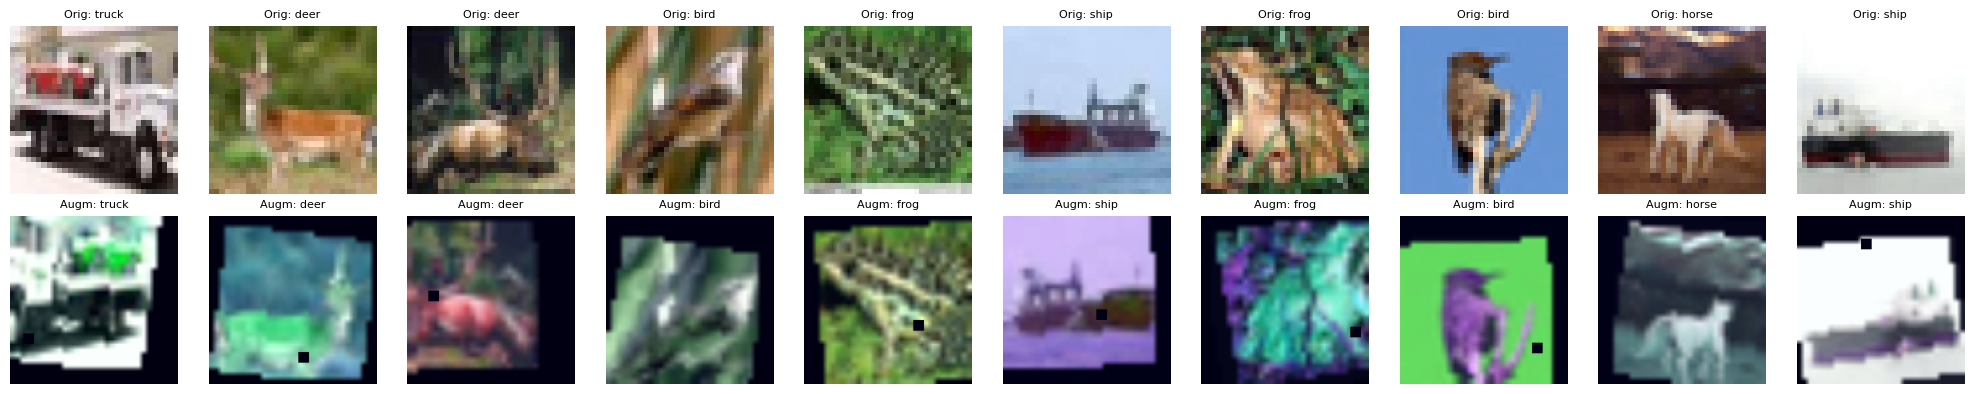

In [23]:
# Visualize random samples from the dataset
print("\n🖼️ Random samples from the dataset:")
show_random_samples(raw_dataset, train_dataset, class_names, n=10)


📈 Class distribution in the dataset:


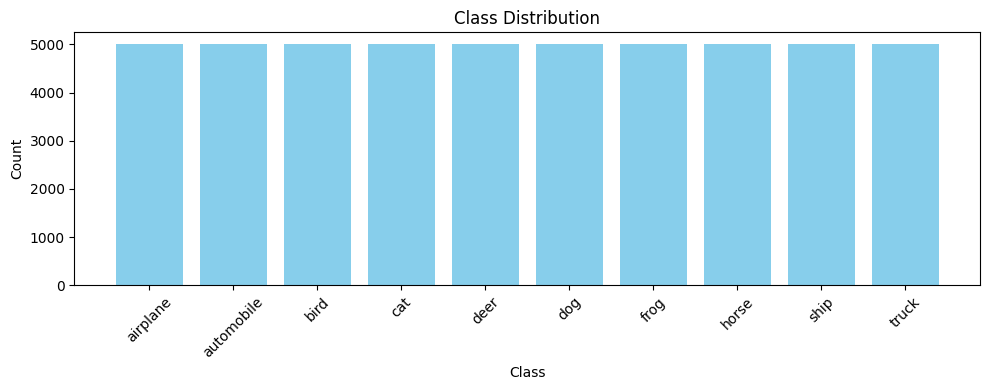

In [24]:
# Show class distribution
print("\n📈 Class distribution in the dataset:")
show_class_distribution(raw_dataset, class_names)

## Model Building and Training

### Model Initialization

In [27]:
# Model building and compilation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape, num_classes = get_dataset_info(train_dataset)

if grayscale:
    input_shape = (1, input_shape[1], input_shape[2])

# Build model
model_cls = CIFAR10Classifier(
    name=model_name,
    input_shape=input_shape,
    num_classes=num_classes,
    model_type=model_type,
    model_kwargs=model_kwargs,
    optimizer_name=optimizer_name,
    optimizer_kwargs=optimizer_kwargs,
    criterion_name=criterion_name,
    criterion_kwargs=criterion_kwargs,
    device=device,
    mean=mean.tolist(),
    std=std.tolist(),
    lr_scheduler_name=lr_scheduler_name,
    lr_scheduler_kwargs=lr_scheduler_kwargs,
    augmentation=augmentation,
    grayscale=grayscale,
    resize=resize
)
model_cls.build_model()
model_cls.compile()

print(f"🧮 Total trainable parameters: {sum(p.numel() for p in model_cls.model.parameters() if p.requires_grad):,}")

🔍 Extracting dataset info...
✅ Input shape: torch.Size([3, 126, 126]), Number of classes: 10
Debug: Dropout schedule: [0.0, 0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5]
Debug: Conv channels: [320, 320, 640, 640, 960, 960, 1280, 1280, 1600, 1600, 1920, 1920]
🧮 Total trainable parameters: 45,733,770


The summary below shows the structure of the CNN model, including all convolutional and fully connected layers.

In [155]:
model_cls.summary()

Layer (type:depth-idx)                        Output Shape              Param #
CIFAR10_ResNet18                              [1, 10]                   --
├─ResNet: 1-1                                 [1, 10]                   --
│    └─Conv2d: 2-1                            [1, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                       [1, 64, 32, 32]           128
│    └─ReLU: 2-3                              [1, 64, 32, 32]           --
│    └─Identity: 2-4                          [1, 64, 32, 32]           --
│    └─Sequential: 2-5                        [1, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 32, 32]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 32, 32]           73,984
│    └─Sequential: 2-6                        [1, 128, 16, 16]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 16, 16]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 16, 16]          295,42

### Training Process

In [156]:
# Start training
model_cls.train(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    verbose=True,
    log_tensorboard=True
)


🚀 Training configuration:
🧱 Architecture:      CIFAR10_ResNet18
📦 Model name:        resnet18_opt-adam_aug-on
📐 Input shape:       torch.Size([3, 32, 32])
⚙️ Activation:        None
📈 Optimizer:         Adam
   {'lr': 0.001}
🎯 Criterion:         CrossEntropyLoss
   {}
🎯 Lr scheduler:      ReduceLROnPlateau
   {'factor': 0.5, 'min_lr': 1e-06, 'mode': 'min', 'patience': 3}
🧠 Device:            cuda
📊 Epochs:            200
🪄 Early stopping:    True (patience=10)

Epoch 1: Learning Rate = 0.001000
[1/200] Train loss: 1.9807, acc: 0.2146 | Val loss: 1.6825, acc: 0.4023 | 🕒 50.50s
Epoch 2: Learning Rate = 0.001000
[2/200] Train loss: 1.6588, acc: 0.3028 | Val loss: 1.3447, acc: 0.5331 | 🕒 53.19s
Epoch 3: Learning Rate = 0.001000
[3/200] Train loss: 1.5327, acc: 0.3471 | Val loss: 1.0754, acc: 0.6384 | 🕒 52.20s
Epoch 4: Learning Rate = 0.001000
[4/200] Train loss: 1.4239, acc: 0.3687 | Val loss: 1.0594, acc: 0.6431 | 🕒 53.75s
Epoch 5: Learning Rate = 0.001000
[5/200] Train loss: 1.3666, acc

In [157]:
print(f"🔎 View TensorBoard logs: tensorboard --logdir=runs/{model_cls.name}")

🔎 View TensorBoard logs: tensorboard --logdir=runs/resnet18_opt-adam_aug-on


## Results and Analysis

### Training History Visualization

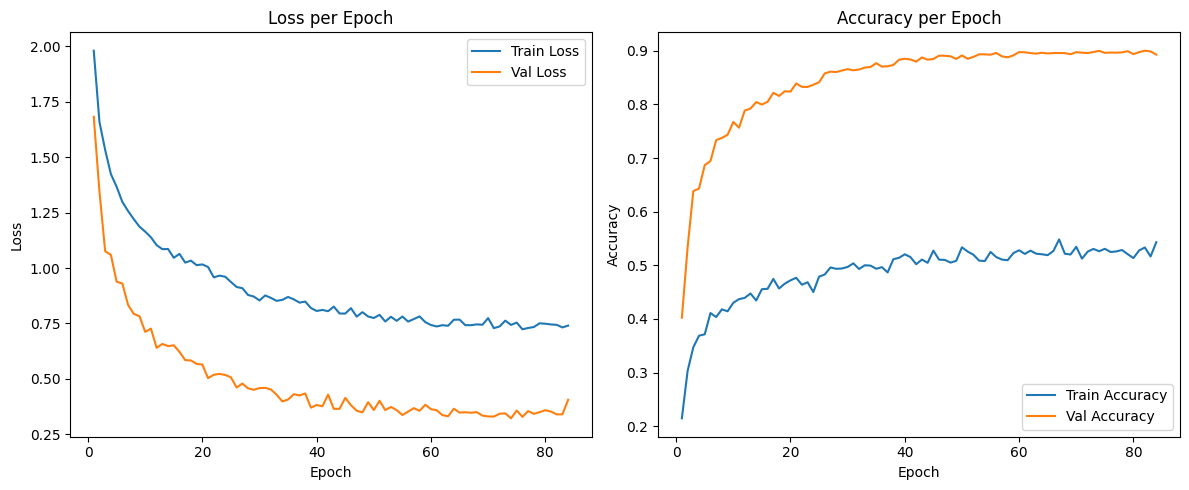

In [158]:
# Load and plot training history
with open(metrics_path, 'r') as f:    
    history = json.load(f)

if not history:
    print("⚠️ No training history found.")
else:
    plot_training_history(history)

In [159]:
# Print training summary
best_epoch = max(history, key=lambda x: x['val_accuracy'])
print("\n📊 Training Summary:")
print(f"Best validation accuracy: {best_epoch['val_accuracy']:.4f} (Epoch {best_epoch['epoch']})")
print(f"Best validation loss: {best_epoch['val_loss']:.4f}")
print(f"Training time: {sum(h['epoch_time'] for h in history):.2f} seconds")
print(f"Total epochs: {len(history)}")
print(f"Final learning rate: {best_epoch.get('learning_rate', 'N/A')}")


📊 Training Summary:
Best validation accuracy: 0.9001 (Epoch 82)
Best validation loss: 0.3393
Training time: 4599.56 seconds
Total epochs: 84
Final learning rate: 1.5625e-05


#### Model Evaluation

Validation loss: 0.4058, accuracy: 0.8960

📊 Validation Results:
Overall accuracy: 0.8960


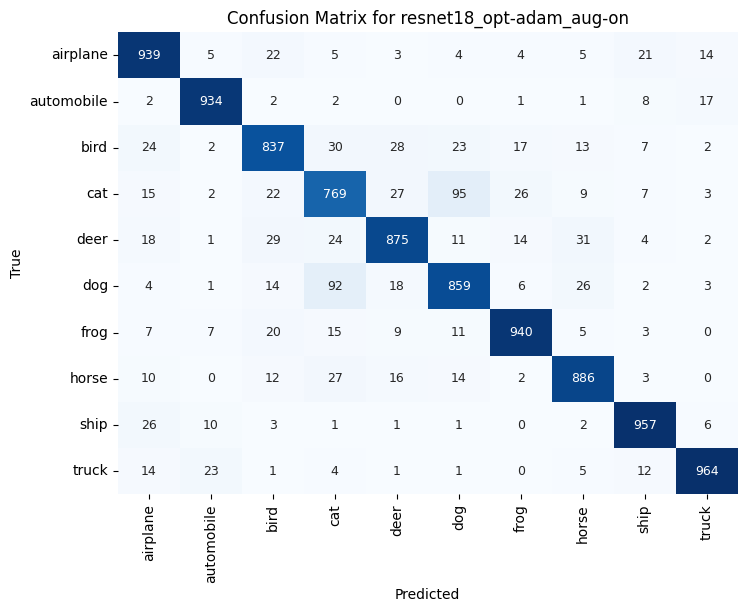

In [160]:
# Model evaluation
metrics = model_cls.evaluate(val_loader)
val_accuracy = metrics['accuracy']
print(f"\n📊 Validation Results:")
print(f"Overall accuracy: {val_accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(
    metrics["y_pred"],
    metrics["y_true"],
    class_names=class_names,
    model_name=model_name
)

#### Model Analysis

In [ ]:
# Print per-class accuracy
print("\n📊 Per-class accuracy:")
print_per_class_accuracy(metrics["y_true"], metrics["y_pred"], class_names)

# Analyze training dynamics
train_acc = [h['train_accuracy'] for h in history]
val_acc = [h['val_accuracy'] for h in history]
train_loss = [h['train_loss'] for h in history]
val_loss = [h['val_loss'] for h in history]

# Calculate overfitting gap
overfitting_gap = max(train_acc) - max(val_acc)
print("\n🔍 Model Analysis:")
print(f"Overfitting gap: {overfitting_gap:.4f}")
print(f"Training accuracy range: {min(train_acc):.4f} - {max(train_acc):.4f}")
print(f"Validation accuracy range: {min(val_acc):.4f} - {max(val_acc):.4f}")

# Analyze learning rate changes
lr_changes = [h.get('learning_rate', None) for h in history if 'learning_rate' in h]
if lr_changes:
    print(f"\n📈 Learning rate changes:")
    print(f"Initial LR: {lr_changes[0]}")
    print(f"Final LR: {lr_changes[-1]}")
    print(f"Number of LR reductions: {len(set(lr_changes)) - 1}")

# Analyze convergence
convergence_epoch = next(
    (i for i, h in enumerate(history) 
     if h['val_accuracy'] >= 0.95 * max(val_acc)),
    None
)
if convergence_epoch is not None:
    print(f"\n⚡ Convergence Analysis:")
    print(f"Model reached 95% of best accuracy at epoch {convergence_epoch + 1}")
    print(f"Convergence time: {sum(h['epoch_time'] for h in history[:convergence_epoch + 1]):.2f} seconds")

# Save final results
results = {
    'model_name': model_name,
    'best_epoch': best_epoch['epoch'],
    'best_val_accuracy': best_epoch['val_accuracy'],
    'best_val_loss': best_epoch['val_loss'],
    'final_val_accuracy': val_accuracy,
    'training_time': sum(h['epoch_time'] for h in history),
    'total_epochs': len(history),
    'overfitting_gap': overfitting_gap,
    'convergence_epoch': convergence_epoch + 1 if convergence_epoch is not None else None,
    'learning_rate_changes': len(set(lr_changes)) - 1 if lr_changes else 0
}

results_path = os.path.join(MODELS_DIR, model_name, f"{model_name}_results.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"\n✅ Results saved to {results_path}")


📊 Per-class accuracy:
airplane: 0.8867 0.9188 0.9025
automobile: 0.9482 0.9659 0.9570
bird: 0.8701 0.8515 0.8607
cat: 0.7936 0.7887 0.7912
deer: 0.8947 0.8672 0.8807
dog: 0.8430 0.8380 0.8405
frog: 0.9307 0.9243 0.9275
horse: 0.9013 0.9134 0.9073
ship: 0.9346 0.9503 0.9424
truck: 0.9535 0.9405 0.9470

🔍 Model Analysis:
Overfitting gap: -0.3518
Training accuracy range: 0.2146 - 0.5483
Validation accuracy range: 0.4023 - 0.9001

📈 Learning rate changes:
Initial LR: 0.001
Final LR: 7.8125e-06
Number of LR reductions: 7

⚡ Convergence Analysis:
Model reached 95% of best accuracy at epoch 26
Convergence time: 1385.87 seconds

✅ Results saved to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\models\resnet18_opt-adam_aug-on\resnet18_opt-adam_aug-on_results.json


: 